## Importing CWA data files
In this notebook, we are going to import the sensor data stored in different CWA files. We are going to pre-process this data using a sliding-window technique in order to generate smaller batches.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import matplotlib.ticker as ticker
from openmovement.load import CwaData

### Patient-specific CWA file
We choose a specific file from patient No. 503, which corresponds to group No. 1

In [2]:
filename = '../01_520/01_520_3.CWA'

In [3]:
with CwaData(filename, include_gyro=True, include_temperature=False) as cwa_data:
    # As an ndarray of [time,accel_x,accel_y,accel_z,temperature]
    #sample_values = cwa_data.get_sample_values()
    # As a pandas DataFrame
    # (keys: ['time','accel_x','accel_y','accel_z','gyro_x','gyro_y','gyro_z','temperature'])
    samples = cwa_data.get_samples()
    samples = samples.set_index('time')
    samples = samples.astype('float32')
    print(samples.size)

120513840


We can display a summary table to visualize the available measurements 

In [4]:
samples

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
time,,,,,,
2022-02-20 20:39:07.091165952,-0.001953,-1.103516,0.063477,-0.549316,0.061035,0.122070
2022-02-20 20:39:07.095108096,-0.000977,-1.105469,0.064941,-0.549316,0.183105,-0.061035
2022-02-20 20:39:07.099049984,-0.000488,-1.102051,0.065430,-0.549316,0.122070,0.183105
2022-02-20 20:39:07.102992128,-0.000977,-1.105469,0.063965,-0.610352,0.183105,0.061035
2022-02-20 20:39:07.106933760,0.000977,-1.105469,0.065430,-0.488281,0.244141,-0.061035
...,...,...,...,...,...,...
2022-02-23 03:38:48.729766912,0.043945,0.889160,0.064453,-0.549316,0.183105,0.122070
2022-02-23 03:38:48.729766912,0.044922,0.888184,0.064453,-0.488281,0.183105,0.122070
2022-02-23 03:38:48.729766912,0.047363,0.888672,0.064941,-0.549316,0.183105,0.122070


In [5]:
samples.describe()

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
count,2.008564e+07,2.008564e+07,2.008564e+07,2.008564e+07,2.008564e+07,2.008564e+07
mean,2.095720e-01,-3.496465e-01,1.404055e-01,-3.408521e-01,2.105628e-01,7.502110e-02
std,4.909602e-01,7.146261e-01,3.579520e-01,2.481939e+01,3.889569e+01,2.765678e+01
min,-1.522949e+01,-9.995605e+00,-8.310059e+00,-8.849487e+02,-1.999939e+03,-1.368652e+03
25%,-1.660156e-01,-1.086914e+00,-9.326172e-02,-6.103516e-01,6.103516e-02,0.000000e+00
50%,4.394531e-02,-3.847656e-01,6.396484e-02,-4.882812e-01,1.220703e-01,6.103516e-02
75%,6.757812e-01,2.734375e-01,3.178711e-01,-4.272461e-01,2.441406e-01,1.220703e-01
max,1.534473e+01,1.460059e+01,1.322998e+01,1.527222e+03,1.999939e+03,1.505371e+03


For visualization purposes, we procceed to plot the first 10,000 measurements corresponding to the gyroscope's x-axis 

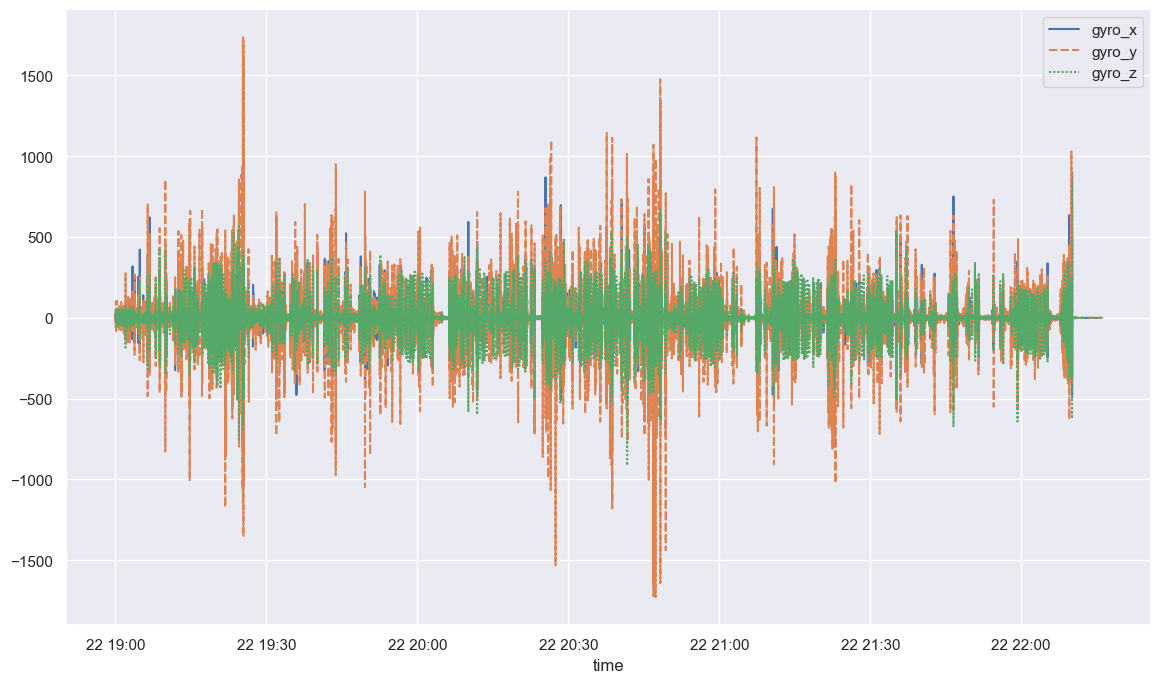

In [17]:
start_time = "2022-02-22 19"
end_time = "2022-02-22 22:15"

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=samples[start_time:end_time].loc[:,['gyro_x','gyro_y','gyro_z']])

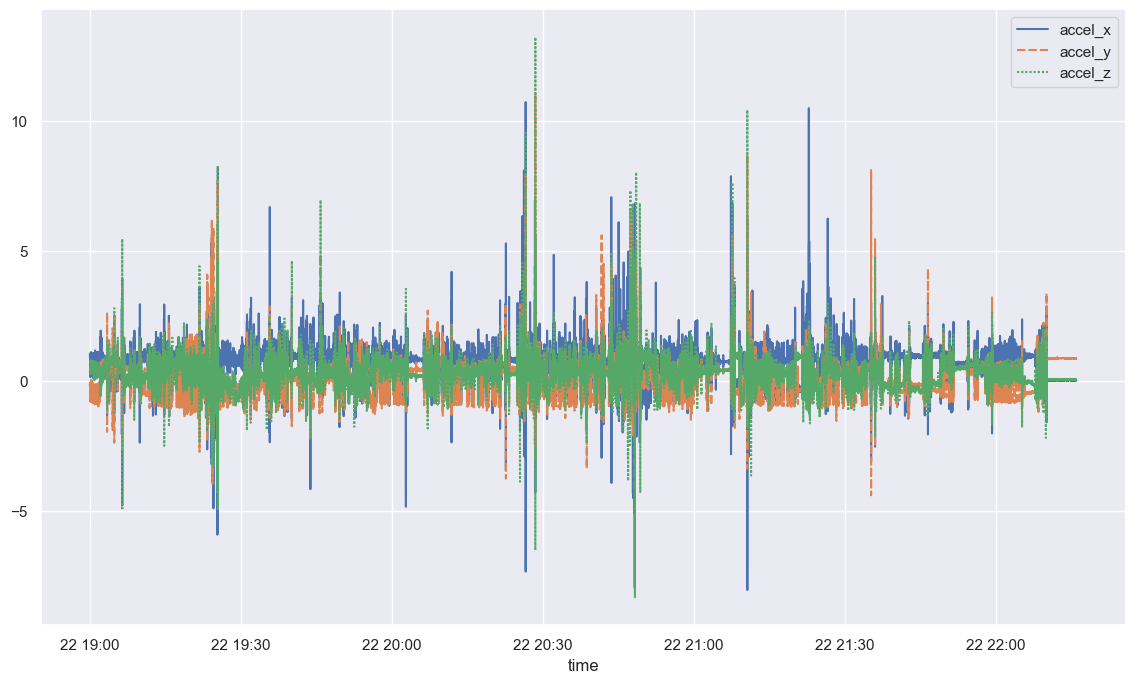

In [18]:
ax2 = sns.lineplot(data=samples[start_time:end_time].loc[:,['accel_x','accel_y','accel_z']])

### Data filtering
We can also apply a low-pass filter (i.e.: a butterworth filter) to denoise the signal

In [ ]:
from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, np.ravel(data))
    return y

In [ ]:
samples_filt = samples
for var in samples.keys():
    samples_filt[var] = butter_lowpass_filter(data=samples_filt[var], cutoff=20, fs=100, order=5)

In [ ]:
ax3 = sns.lineplot(data=samples_filt[start_time:end_time].loc[:,['gyro_x','gyro_y','gyro_z']])

In [ ]:
ax2 = sns.lineplot(data=samples_filt[start_time:end_time].loc[:,['accel_x','accel_y','accel_z']])

In [ ]:
samples[start_time:end_time].shape